In [154]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from census import Census
# matplotlib.style.use('ggplot')


all_listings = pd.read_csv("boston_area_airbnb_listings_july_2015.csv")

In [3]:
all_listings.drop_duplicates("room_id")
clean = all_listings

One of the major issues with Airbnb concerns whether hosts are commercial or casual hosts. Unambiguously, we can calculate the share of listings that are "whole unit" listings:

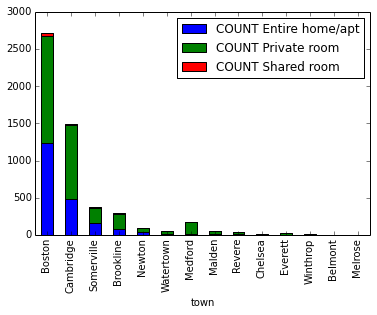

In [141]:
widened = pd.DataFrame(clean[["town","room_type","COUNT"]].groupby(["town","room_type"], sort=True).count()).unstack()
widened.columns = [' '.join(col).strip() for col in widened.columns.values]
widened = widened.fillna(0).reset_index() #flattens the nested tabular structure and fills NaNs.

#calculate percentages
widened.loc[:,"total"] = widened[[1,2,3]].sum(axis=1)
widened.loc[:,"entire_pct"] = widened.loc[:,"COUNT Entire home/apt"] / widened.loc[:,"total"]
widened.loc[:,"private_pct"] = widened.loc[:,"COUNT Private room"] / widened.loc[:,"total"]
widened.loc[:,"share_pct"] = widened.loc[:,"COUNT Shared room"] / widened.loc[:,"total"]
widened[["COUNT Entire home/apt","COUNT Private room","COUNT Shared room","town"]].sort("COUNT Entire home/apt", ascending=False).plot(x="town",kind="bar", stacked=True)

We can see that share of room type differences across the spectrum. In Somerville, we can see that about __42 percent__ of active listings book the entire unit. 

Now let's determine the average price to understand what units are worth in the Boston area:

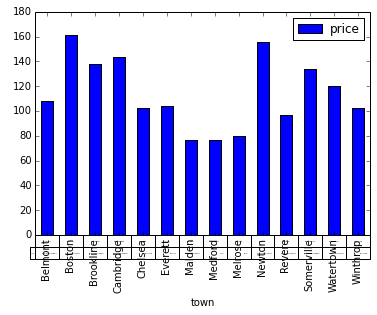

In [150]:
avg_price = pd.DataFrame(clean[["town","price"]]).groupby(["town"]).mean().reset_index()
avg_price.plot(kind="bar", x="town")
# avg_price["price"]= avg_price["price"].map('${:,.2f}'.format)


# Revenue Estimates

This analysis uses the "San Francisco Model" to estimate the income earned from listings. This is calculated as follows:

__Review Rate x Average Length of Stay x Nightly Rate = Income Earned__

According to [Inside Airbnb](http://insideairbnb.com/about.html):

>A Review Rate of 50% is used to convert reviews to estimated bookings. Alex Marqusee uses a review rate of 72%, however this is attributed to an unreliable source: Airbnb's CEO and co-founder Brian Chesky. The Budget and Legislative Analyst's Office (page 49) also use a value 72% for their review rate, and in addition, introduce a higher impact model using a review rate of 30.5% - based on comparing public data of reviews to the The New York Attorney General’s report on Airbnb released in October 2014. Inside Airbnb analysis found that using a review rate 30.5% is more fact based, however probably not conservative enough, given that the Budget and Legislative Analyst's Office did not take into account missing reviews because of deleted listings. A review rate of 72% is unverifiable - therefore 50% was chosen as it sits almost exactly between 72% and 30.5%.

Because the review rate multiplier most significantly affects the income earned, this analysis will present the estimat as a range of income using all three reported averages.

Using 2015 statistics from the [Boston Business Journal and Pinnacle Advisory Group](http://www.bostonusa.com/partner/press/statistics/), the average number of nights for domestic and international travelers was 3.4. Airbnb sometimes reports average length of stay for particular cities. This information has not been reported for Boston, so using the hotel and lodging market as a proxy, we used 3.4 as an estimate for the Average Length of Stay. Where the reported count of minimum nights is higher than 3.4, we used the minimum nights.

Finally, because the Nightly Rate is provided unambiguously, we multiply these factors by the listed Nightly Rate. 


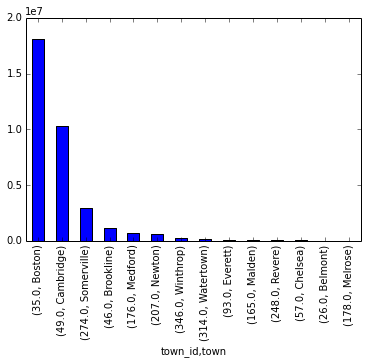

In [3]:
est_avg_len_stay = 3.4
clean.loc[:,"avg_len_stay"] = est_avg_len_stay
clean.loc[clean["minstay"] > est_avg_len_stay, "avg_len_stay"] = clean["minstay"]
clean.loc[:,"est_income"] = clean["reviews"] * clean["avg_len_stay"] * clean["price"]
pivot = pd.pivot_table(clean, columns=["town_id","town"], values="est_income", aggfunc=np.sum)
plt.figure(); pivot.sort("est_income", ascending=False);
pivot.plot(kind="bar")

Let's normalize these values per capita

In [5]:
c = Census("ce63599ea52eeb2224f5fd0c510271526831e462")
c.acs.get()